Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data already extracted.
Extracted to: /content/deap_dataset
Sample files: ['s11.dat', 's16.dat', 's03.dat', 's01.dat', 's15.dat']
Using data directory: /content/deap_dataset
Loaded data: (480, 40, 8064), labels: (480, 4)
Class balance: [227 253]
Normalizing EEG data...
Normalized EEG data shape: (480, 40, 8064)
Segmenting EEG data...
Segmented data shape: (7200, 40, 512) Labels: (7200,)
EEG_CNN_BiLSTM(
  (conv): Sequential(
    (0): Conv1d(40, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Ma

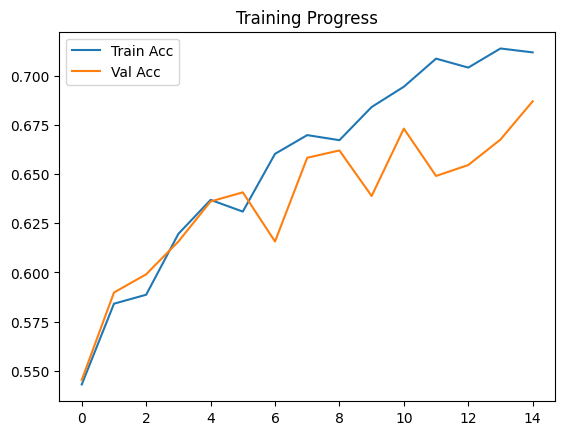


Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69       511
           1       0.73      0.70      0.71       569

    accuracy                           0.70      1080
   macro avg       0.70      0.70      0.70      1080
weighted avg       0.70      0.70      0.70      1080


Confusion Matrix:
 [[359 152]
 [168 401]]


In [17]:


import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pickle
import zipfile
import warnings
warnings.filterwarnings("ignore")


from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/archive (2).zip"
extract_dir = "/content/deap_dataset"

if not os.path.exists(extract_dir):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction complete.")
else:
    print("Data already extracted.")

print("Extracted to:", extract_dir)
print("Sample files:", os.listdir(extract_dir)[:5])


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


data_folder = None
for root, dirs, files in os.walk(extract_dir):
    if any(f.endswith(".dat") for f in files):
        data_folder = root
        break

if not data_folder:
    raise FileNotFoundError("No .dat files found in extracted data!")

print(f"Using data directory: {data_folder}")


def load_deap(data_dir):
    all_data, all_labels = [], []
    for filename in sorted(os.listdir(data_dir)):
        if filename.endswith(".dat"):
            filepath = os.path.join(data_dir, filename)
            with open(filepath, 'rb') as f:
                subject = pickle.load(f, encoding='latin1')
                data = subject['data']  # (40, 40, 8064)
                labels = subject['labels']  # (40, 4)
                all_data.append(data)
                all_labels.append(labels)
    X = np.concatenate(all_data, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

X, y = load_deap(data_folder)
print(f"Loaded data: {X.shape}, labels: {y.shape}")


y_valence = (y[:, 0] > 5).astype(int)
print("Class balance:", np.bincount(y_valence))

def normalize_eeg(X):
    Xn = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            ch = X[i, j]
            Xn[i, j] = (ch - np.mean(ch)) / (np.std(ch) + 1e-8)
    return Xn

print("Normalizing EEG data...")
X = normalize_eeg(X)
print("Normalized EEG data shape:", X.shape)

def segment_data(X, y, segment_len=512):
    X_seg, y_seg = [], []
    for i in range(len(X)):
        trial = X[i]
        for start in range(0, trial.shape[1] - segment_len + 1, segment_len):
            seg = trial[:, start:start + segment_len]
            X_seg.append(seg)
            y_seg.append(y[i])
    return np.array(X_seg), np.array(y_seg)

print("Segmenting EEG data...")
X_seg, y_seg = segment_data(X, y_valence, segment_len=512)
print("Segmented data shape:", X_seg.shape, "Labels:", y_seg.shape)


class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

X_train, X_temp, y_train, y_temp = train_test_split(X_seg, y_seg, test_size=0.3, stratify=y_seg)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

train_loader = DataLoader(EEGDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(EEGDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(EEGDataset(X_test, y_test), batch_size=64)

# =======================
# 6️⃣ Model Definition
# =======================
class EEG_CNN_BiLSTM(nn.Module):
    def __init__(self, in_channels, num_classes=2, hidden_size=128, lstm_layers=1, dropout=0.3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        dummy = torch.zeros(1, in_channels, 512)
        with torch.no_grad():
            conv_out = self.conv(dummy)
        self.bilstm = nn.LSTM(input_size=conv_out.shape[1], hidden_size=hidden_size,
                              num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = out.mean(dim=1)
        return self.fc(out)

num_channels = X_seg.shape[1]
model = EEG_CNN_BiLSTM(in_channels=num_channels).to(DEVICE)
print(model)

# =======================
# 7️⃣ Training
# =======================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 15

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_correct = 0, 0
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        total_correct += (outputs.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

def eval_epoch(model, loader):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            outputs = model(X)
            loss = criterion(outputs, y)
            total_loss += loss.item() * X.size(0)
            total_correct += (outputs.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

train_acc_list, val_acc_list = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer)
    val_loss, val_acc = eval_epoch(model, val_loader)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.legend()
plt.title("Training Progress")
plt.show()

# =======================
# 8️⃣ Evaluation
# =======================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        outputs = model(X)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.cpu().numpy())

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [18]:
import random

# --- Pick random samples from the test set ---
model.eval()
samples = random.sample(range(len(test_loader.dataset)), 10)  # 10 random examples

X_all = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
y_all = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

with torch.no_grad():
    outputs = model(X_all)
    preds = outputs.argmax(1).cpu().numpy()

# Display 10 random predictions
print(" Sample Predictions vs True Labels:\n")
for idx in samples:
    print(f"Sample {idx:03d} | True: {y_test[idx]} | Predicted: {preds[idx]}")


🧩 Sample Predictions vs True Labels:

Sample 108 | True: 0 | Predicted: 1
Sample 337 | True: 1 | Predicted: 0
Sample 186 | True: 1 | Predicted: 1
Sample 535 | True: 1 | Predicted: 0
Sample 806 | True: 1 | Predicted: 1
Sample 612 | True: 1 | Predicted: 0
Sample 500 | True: 1 | Predicted: 1
Sample 495 | True: 1 | Predicted: 1
Sample 780 | True: 0 | Predicted: 1
Sample 235 | True: 1 | Predicted: 1


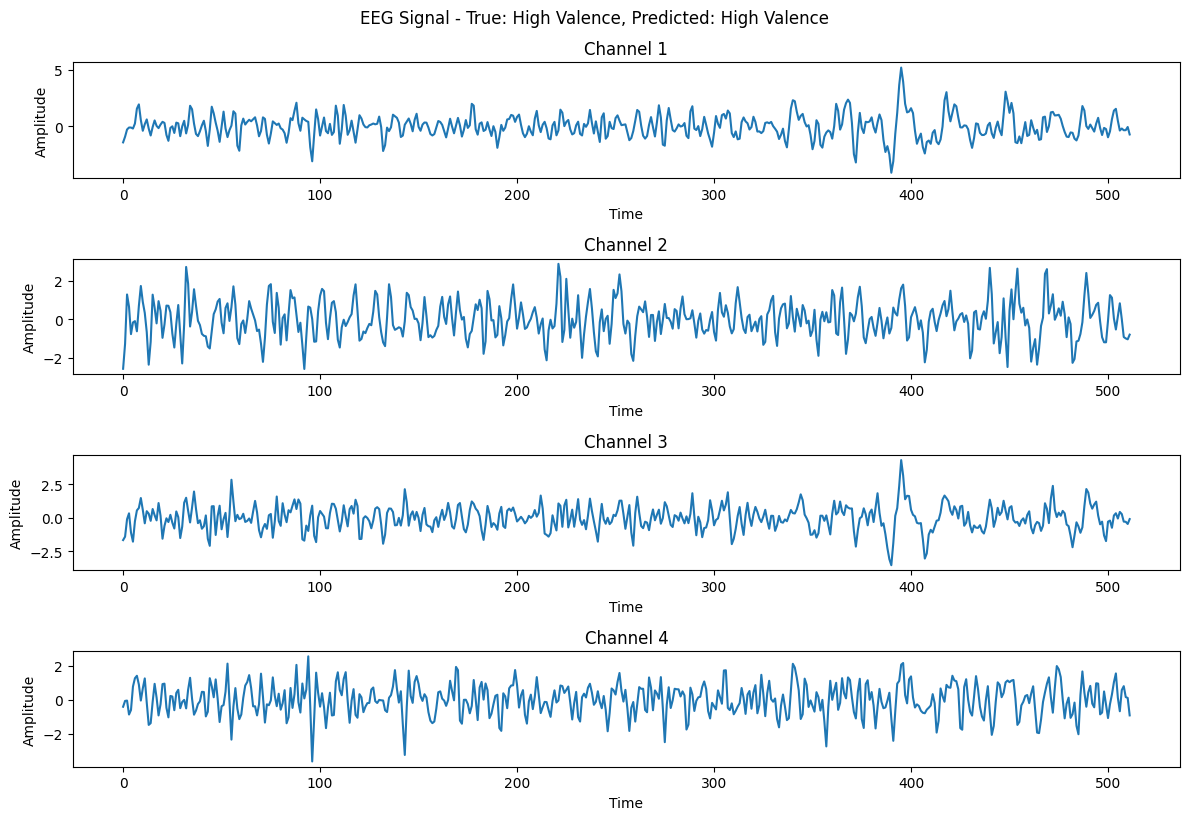

In [20]:
# --- Pick one EEG trial to visualize ---
sample_idx = random.randint(0, len(X_test) - 1)
trial = X_test[sample_idx]  # shape: (channels, time)
true_label = y_test[sample_idx]
pred_label = preds[sample_idx]

# Define a mapping for the labels
label_map = {0: 'Low Valence', 1: 'High Valence'}

# Pick a few channels to visualize (say first 4)
channels_to_show = [0, 1, 2, 3]
time_axis = np.arange(trial.shape[1])

plt.figure(figsize=(12, 8))
for i, ch in enumerate(channels_to_show):
    plt.subplot(len(channels_to_show), 1, i + 1)
    plt.plot(time_axis, trial[ch])
    plt.title(f"Channel {ch+1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.suptitle(f"EEG Signal - True: {label_map[true_label]}, Predicted: {label_map[pred_label]}", y=1.02)
plt.show()

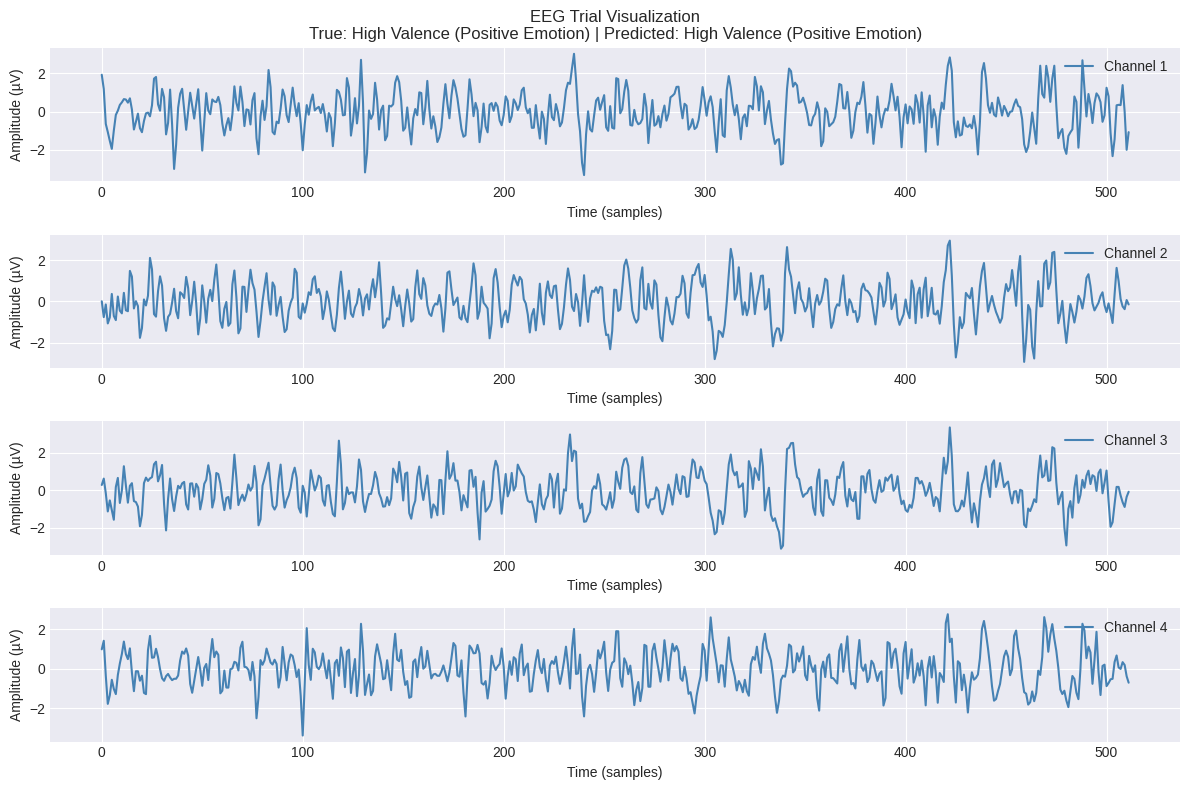

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Define label names
label_map = {0: "Low Valence (Negative Emotion)", 1: "High Valence (Positive Emotion)"}

# --- Pick a random EEG trial from test set ---
sample_idx = random.randint(0, len(X_test) - 1)
trial = X_test[sample_idx]  # shape: (channels, time)
true_label = y_test[sample_idx]
pred_label = preds[sample_idx]

# --- Select channels to visualize (e.g., 4 representative EEG channels) ---
channels_to_show = [0, 1, 2, 3]
time_axis = np.arange(trial.shape[1])

plt.figure(figsize=(12, 8))
plt.style.use("seaborn-v0_8-darkgrid")

for i, ch in enumerate(channels_to_show):
    plt.subplot(len(channels_to_show), 1, i + 1)
    plt.plot(time_axis, trial[ch], color='steelblue', label=f"Channel {ch+1}")
    plt.legend(loc="upper right")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (µV)")
    if i == 0:
        plt.title(f"EEG Trial Visualization\nTrue: {label_map[true_label]} | Predicted: {label_map[pred_label]}")

plt.tight_layout()
plt.show()
